In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata
import bbknn
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy import sparse

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()

np.random.seed(0)  # to get reproducible results

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


scanpy==1.3.1 anndata==0.6.10 numpy==1.14.0 scipy==1.0.0 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 


#### Read in the batch information (simulated batch from R)
##### set index_col, so read in the column names as are

In [2]:
#df_batch1 = pd.read_csv("/Users/Miko/Downloads/samples/sample1.csv", index_col='Unnamed: 0')
#df_batch2 = pd.read_csv("/Users/Miko/Downloads/samples/sample2.csv", index_col='Unnamed: 0')

df_batch1 = pd.read_csv("/Users/Miko/Downloads/python_batch3+4/sample3.csv.gz", index_col='Unnamed: 0')
df_batch2 = pd.read_csv("/Users/Miko/Downloads/python_batch3+4/sample4.csv.gz", index_col='Unnamed: 0')

In [3]:
df_batch1.shape

(295, 5000)

In [4]:
df_batch1.head()

,Gene1,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8,Gene9,Gene10,...,Gene4991,Gene4992,Gene4993,Gene4994,Gene4995,Gene4996,Gene4997,Gene4998,Gene4999,Gene5000
Cell1-3,10.220316,11.995088,10.198690,7.968123,8.564101,7.178924,9.212526,8.028220,11.746717,7.861705,...,10.316527,8.871428,8.917121,10.167117,8.188122,9.991928,6.425450,8.775106,8.377655,8.253642
Cell2-3,10.372036,13.156107,10.288944,7.065761,8.534148,12.406017,6.422765,7.252464,9.386402,5.456184,...,8.977967,8.771292,6.404020,7.328005,8.355491,6.120217,7.731856,7.925778,8.717438,7.336340
Cell3-3,10.403966,11.321794,7.912397,6.631898,10.766221,11.255110,7.269181,7.869271,11.816656,7.564399,...,10.275852,8.713709,6.553525,4.635773,9.001863,10.131524,6.853702,7.017126,9.943479,6.877132
Cell4-3,8.887136,11.109219,8.754470,7.295652,10.234685,10.761423,8.349413,8.361570,10.376526,6.866101,...,10.895683,8.868509,9.116140,5.258644,4.946027,8.727766,9.383376,9.584959,8.869277,6.463251
Cell5-3,9.988600,12.417948,7.906731,4.723899,9.765187,11.206312,7.932423,7.415649,9.811966,5.514345,...,10.511583,6.633456,6.670289,9.122336,8.763687,9.560964,9.358403,6.632563,8.820504,8.307982


In [5]:
batch1 = df_batch1.values

In [6]:
df_batch2.shape

(250, 5000)

In [7]:
df_batch2.head()

,Gene1,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8,Gene9,Gene10,...,Gene4991,Gene4992,Gene4993,Gene4994,Gene4995,Gene4996,Gene4997,Gene4998,Gene4999,Gene5000
Cell1-4,8.395110,8.473093,10.443839,6.596194,9.293229,7.020344,8.339506,11.288293,5.005206,9.747422,...,8.694059,7.010427,9.992951,10.402101,4.980186,6.975874,8.098540,5.737538,9.324789,7.024321
Cell2-4,6.860389,7.520405,11.073073,9.551838,6.933062,7.092404,10.632303,10.455837,5.585345,11.276045,...,7.667114,6.626665,6.844288,7.139273,5.460602,8.660949,7.652841,7.985009,10.732740,6.871477
Cell3-4,6.255274,8.099752,11.384033,10.621391,6.561389,5.272711,9.516872,9.989031,5.378268,10.085753,...,9.762812,8.857033,6.845156,8.361141,6.462867,5.204812,9.092187,7.497799,8.548918,5.159124
Cell4-4,4.139662,7.768112,8.166936,7.081274,10.384801,7.780603,9.992350,7.945762,6.386301,8.037008,...,7.835813,5.471244,10.404685,7.636046,5.286656,7.764419,9.288859,8.582977,8.830321,7.110521
Cell5-4,6.292649,6.960326,9.845567,5.574103,6.612582,7.131531,9.910150,10.105619,6.767205,9.862328,...,7.090859,7.906696,8.278710,7.279725,6.113244,6.387299,5.076148,6.423705,6.412603,8.563815


In [8]:
batch2 = df_batch2.values

#### Create an AnnData object with the data, adding metadata identifying each cell's original cell type and batch.

In [9]:
adata = anndata.AnnData(X=np.vstack((df_batch1, df_batch2)))

In [10]:
adata.X.shape

(545, 5000)

In [11]:
# get original data
ori_data = adata.X
ori_data = np.asmatrix(ori_data)
type(ori_data)

numpy.matrixlib.defmatrix.matrix

#### Read in batch and cell type information

In [12]:
#batch_id = open("/Users/Miko/Downloads/batch.info/batch.id.txt", "r")
batch_id = open("/Users/Miko/Downloads/python_batch3+4/batch.id.1.txt", "r")
batch_list = batch_id.read().splitlines()

In [13]:
#cell_type = open("/Users/Miko/Downloads/batch.info/cell.type.txt", "r")
cell_type = open("/Users/Miko/Downloads/python_batch3+4/cell.type_1.txt", "r")
cell_type_list = cell_type.read().splitlines()

In [14]:
adata.obs['celltype'] = cell_type_list
adata.obs['batch'] = batch_list

#### Identify the standard neighbourhood graph and visualise the cell types and batches in UMAP space. 
#### Unsurprisingly, everything is very heavily split.

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:03.82) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:02.73) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.05) --> found 4 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
... storing 'celltype' as categorical
... storing 'batch' as categorical


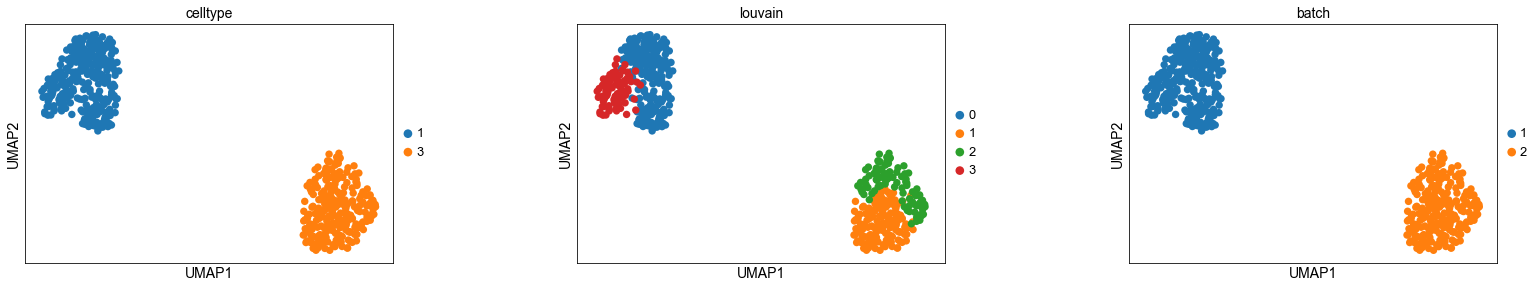

In [15]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.louvain(adata)

sc.pl.umap(adata, color=['celltype','louvain','batch'])

#### Replace the neighbourhood graph inference with BBKNN.
#### Observe as the cell types become reconnected.

In [32]:
adata

AnnData object with n_obs × n_vars = 545 × 5000 
    obs: 'celltype', 'batch', 'louvain'
    uns: 'pca', 'neighbors', 'louvain', 'celltype_colors', 'louvain_colors', 'batch_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

computing batch balanced neighbors
    finished (0:00:02.03) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.81) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.04) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
    number of colors in `.uns[louvain'_colors']` smaller than number of categories, falling back to palette


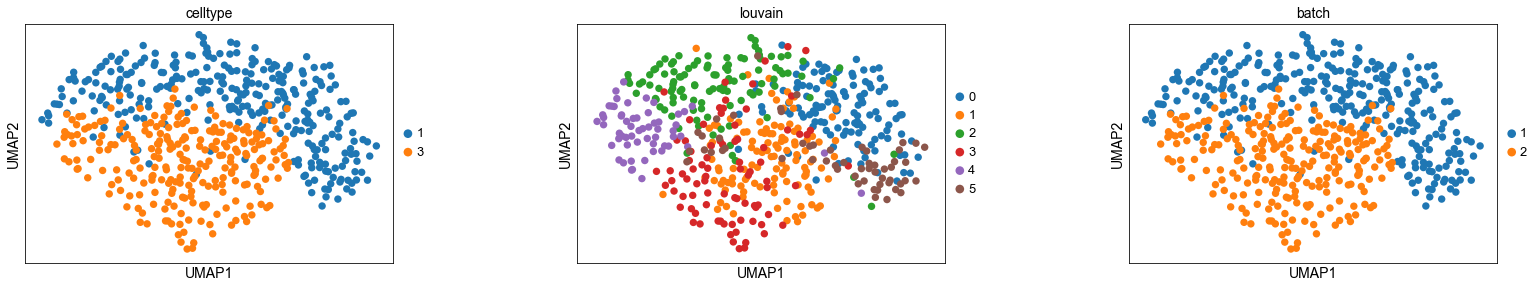

In [16]:
bbknn.bbknn(adata)
sc.tl.umap(adata)
sc.tl.louvain(adata)

sc.pl.umap(adata, color=['celltype','louvain','batch'])

#### Evaluate the effectiveness of batch removal

In [17]:
adata.uns['neighbors'].get('connectivities')

<545x545 sparse matrix of type '<class 'numpy.float64'>'
	with 5252 stored elements in Compressed Sparse Row format>

In [18]:
cell_cell = adata.uns['neighbors'].get('connectivities').todense()

In [19]:
with open('connectivities.txt','wb') as f:
    for line in cell_cell:
        np.savetxt(f, line, fmt='%.2f')

In [20]:
type(cell_cell)

numpy.matrixlib.defmatrix.matrix

In [21]:
ori_data.shape

(545, 5000)

In [22]:
bbknn_matrix = cell_cell * ori_data

In [23]:
bbknn_matrix.shape

(545, 5000)

#### Calculate spearman correlation between the matrix before and after BBKNN 

In [24]:
# get the transpose to use pandas.DataFrame.corr to compute pairwise correlation of columns
t_bbknn = bbknn_matrix.transpose()
t_ori = ori_data.transpose()

In [25]:
df_t_bbknn = pd.DataFrame(t_bbknn)
df_t_ori = pd.DataFrame(t_ori)

In [26]:
df_t_bbknn.shape  # gene by cell: then compute column correlations

(5000, 545)

In [27]:
def spearman_corr_by_cell(num_cells):
    rho_list = []
    for i in range(num_cells):
        rho = df_t_bbknn[i].corr(df_t_ori[i], method= 'spearman')
        rho_list.append(rho)
    return rho_list

In [28]:
num_cells=545
# call the function
rho_list = spearman_corr_by_cell(num_cells)
cell_order = list(range(1, num_cells+1))

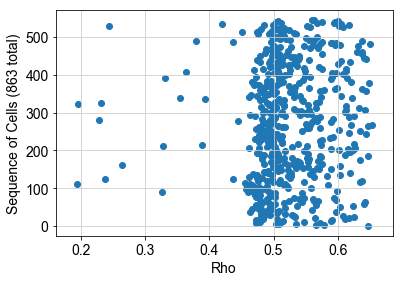

In [29]:
plt.scatter(rho_list, cell_order)
plt.xlabel('Rho')
plt.ylabel('Sequence of Cells (863 total)')
plt.show()

#### Calculate NMI from louvain clustering results

In [30]:
normalized_mutual_info_score(adata.obs.louvain, cell_type_list)

0.22679647670281372

In [31]:
normalized_mutual_info_score(adata.obs.louvain, batch_list)

0.22679647670281372

#### Deprecated: Calculate NMI value to evaluate the effect of batch removal

kmeans clustering 
"""
kmeans = KMeans(n_clusters=3)
kmeans.fit(bbknn_matrix)

labels = kmeans.predict(bbknn_matrix)  # each cell belongs to which cluster
centroids = kmeans.cluster_centers_

normalized_mutual_info_score(labels, cell_type_list)  
normalized_mutual_info_score(labels, batch_list)  
"""